# Imports and Data Loading

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.utils.multiclass import unique_labels

from xgboost import XGBClassifier

import eli5
from eli5.sklearn import PermutationImportance

from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot

import shap

In [2]:
df = pd.read_csv('voterhistorywrangled.csv')

df.head()

,Unnamed: 0,voter_id,06/02/2015,06/06/2017,06/07/2016,11/07/2017,11/08/2016,status_code,party_code,last_name,first_name,sex,street_name,city,birthdate,registered,ballot,county,municipality,district
0,0,101001891,0.0,0.0,1.0,0.0,1.0,A,DEM,GORHAM,GWENDOLYN,F,MERCER AVE,NORTH PLAINFIELD,1965-05-15,2008-10-14,M,11700154.0,NORTH PLAINFIELD,1.0
1,2,101024934,1.0,1.0,1.0,1.0,1.0,A,DEM,BIVINS,DAVETTE,F,NORTH DR,NORTH PLAINFIELD,1932-05-20,2015-11-16,M,11700160.0,NORTH PLAINFIELD,8.0
2,7,101048678,0.0,0.0,0.0,0.0,1.0,A,REP,DEFROSCIA,ESTHER,N,CRYSTAL TER,NORTH PLAINFIELD,1930-08-29,2008-02-06,M,11700157.0,NORTH PLAINFIELD,4.0
3,8,101055274,1.0,1.0,1.0,1.0,1.0,A,DEM,BREWER,GERALDINE,F,HURLEY AVE,NORTH PLAINFIELD,1944-04-13,2009-01-10,M,11700151.0,NORTH PLAINFIELD,2.0
4,13,101062053,0.0,1.0,1.0,1.0,1.0,A,DEM,LEE,MARY,N,MALCOLM AVE,NORTH PLAINFIELD,1946-10-12,2009-10-19,M,11700158.0,NORTH PLAINFIELD,5.0


In [3]:
df = df.drop(columns=['Unnamed: 0','ballot'])

df.head()

,voter_id,06/02/2015,06/06/2017,06/07/2016,11/07/2017,11/08/2016,status_code,party_code,last_name,first_name,sex,street_name,city,birthdate,registered,county,municipality,district
0,101001891,0.0,0.0,1.0,0.0,1.0,A,DEM,GORHAM,GWENDOLYN,F,MERCER AVE,NORTH PLAINFIELD,1965-05-15,2008-10-14,11700154.0,NORTH PLAINFIELD,1.0
1,101024934,1.0,1.0,1.0,1.0,1.0,A,DEM,BIVINS,DAVETTE,F,NORTH DR,NORTH PLAINFIELD,1932-05-20,2015-11-16,11700160.0,NORTH PLAINFIELD,8.0
2,101048678,0.0,0.0,0.0,0.0,1.0,A,REP,DEFROSCIA,ESTHER,N,CRYSTAL TER,NORTH PLAINFIELD,1930-08-29,2008-02-06,11700157.0,NORTH PLAINFIELD,4.0
3,101055274,1.0,1.0,1.0,1.0,1.0,A,DEM,BREWER,GERALDINE,F,HURLEY AVE,NORTH PLAINFIELD,1944-04-13,2009-01-10,11700151.0,NORTH PLAINFIELD,2.0
4,101062053,0.0,1.0,1.0,1.0,1.0,A,DEM,LEE,MARY,N,MALCOLM AVE,NORTH PLAINFIELD,1946-10-12,2009-10-19,11700158.0,NORTH PLAINFIELD,5.0


# Feature Engineering

In [4]:
#big feature engineering cell

#bools for male and female markers
df['male'] = (df['sex'] == 'M')
df['female'] = (df['sex'] == 'F')

#convert dates to datetimes for easier handling
df['birthdate'] = df['birthdate'].apply(pd.to_datetime)
df['registered'] = df['registered'].apply(pd.to_datetime)

#age at time of target election
df['age_2017'] = (pd.to_datetime('11/07/2017') 
                  - df['birthdate']).apply(lambda d: d.days /365)

#age at time of most recent voter registration
df['reg_age'] = (df['registered'] 
                  - df['birthdate']).apply(lambda d: d.days /365)
#if registration supposedly occurred at an implausible age, replace with nan
df['mask'] = df['reg_age'] > 1
df['reg_age'] = df['reg_age'].where(df['mask'],other=np.nan)
df = df.drop(columns='mask')

#how long since registration ("prior" to target election)
#suddenly, the centerpiece of the model
df['since_reg'] = (pd.to_datetime('11/07/2017') 
                  - df['registered']).apply(lambda d: d.days /365)

#bools for party affiliation
#all are wildly unimportant!
df['dem'] = (df['party_code'] == 'DEM')
df['rep'] = (df['party_code'] == 'REP')
df['una'] = (df['party_code'] == 'UNA') #I believe "unaffiliated"
df['3rd'] = ~(df['dem'] | df['rep'] | df['una'])

#feature idea: municipality
#ordinal encoded from lowest to highest target voting rate
muni_map = {'NORTH PLAINFIELD': 1,
            'MANVILLE BOROUGH': 2,
            'GREEN BROOK': 3,
            1: 1,
            2: 2,
            3: 3}#last part protects against loss of data when cell is re-run
df['municipality'] = df['municipality'].map(muni_map)

#naive voter score
#unfair to young voters who would have been unable to vote in earlier elections
#voting rate of previous four elections
df['voter_score'] = (df['06/02/2015'] + df['06/07/2016'] + df['11/08/2016'] + df['06/06/2017']) / 4



df.head()

,voter_id,06/02/2015,06/06/2017,06/07/2016,11/07/2017,11/08/2016,status_code,party_code,last_name,first_name,...,male,female,age_2017,reg_age,since_reg,dem,rep,una,3rd,voter_score
0,101001891,0.0,0.0,1.0,0.0,1.0,A,DEM,GORHAM,GWENDOLYN,...,False,True,52.517808,43.446575,9.071233,True,False,False,False,0.50
1,101024934,1.0,1.0,1.0,1.0,1.0,A,DEM,BIVINS,DAVETTE,...,False,True,85.526027,83.547945,1.978082,True,False,False,False,1.00
2,101048678,0.0,0.0,0.0,0.0,1.0,A,REP,DEFROSCIA,ESTHER,...,False,False,87.252055,77.493151,9.758904,False,True,False,False,0.25
3,101055274,1.0,1.0,1.0,1.0,1.0,A,DEM,BREWER,GERALDINE,...,False,True,73.619178,64.789041,8.830137,True,False,False,False,1.00
4,101062053,0.0,1.0,1.0,1.0,1.0,A,DEM,LEE,MARY,...,False,False,71.120548,63.063014,8.057534,True,False,False,False,0.75


# Data Exploration

In [5]:
df[df['3rd']]

,voter_id,06/02/2015,06/06/2017,06/07/2016,11/07/2017,11/08/2016,status_code,party_code,last_name,first_name,...,male,female,age_2017,reg_age,since_reg,dem,rep,una,3rd,voter_score
217,101552012,0.0,0.0,0.0,0.0,1.0,A,GRE,LITTLE,GREGORY,...,False,False,51.904110,36.838356,15.065753,False,False,False,True,0.25
377,104455443,0.0,0.0,0.0,0.0,1.0,A,GRE,BROXMEYER,DEBORAH,...,False,True,42.210959,41.786301,0.424658,False,False,False,True,0.25
465,104562959,0.0,0.0,1.0,1.0,1.0,A,LIB,HUSSEY-POLAND,PAMELA,...,False,True,49.339726,49.339726,0.000000,False,False,False,True,0.50
952,106188388,0.0,0.0,0.0,0.0,1.0,A,CON,LEWIS,LISA,...,False,True,40.482192,39.334247,1.147945,False,False,False,True,0.25
1156,106362180,0.0,0.0,0.0,1.0,1.0,A,GRE,ZEMPEL,CAROLE,...,False,True,41.076712,30.534247,10.542466,False,False,False,True,0.25
1381,115047522,0.0,0.0,1.0,1.0,1.0,A,LIB,TAYLOR,GERALD,...,True,False,54.824658,53.824658,1.000000,False,False,False,True,0.50
1478,117017860,0.0,0.0,1.0,1.0,1.0,A,GRE,VAN FLEET,LISA,...,False,True,47.498630,17.986301,29.512329,False,False,False,True,0.50
1689,117028342,1.0,0.0,1.0,1.0,1.0,A,LIB,RUSSELL,CASSANDRA,...,False,True,45.895890,20.578082,25.317808,False,False,False,True,0.75
1824,117031571,0.0,0.0,0.0,1.0,1.0,A,LIB,ADAMO,SALVATORE,...,False,False,80.728767,23.498630,57.230137,False,False,False,True,0.25
2710,117052755,0.0,0.0,0.0,1.0,1.0,A,LIB,DE RONER,FRANK,...,False,False,70.364384,32.169863,38.194521,False,False,False,True,0.25


In [6]:
df['since_reg'].describe()
#some negative values...

count    21690.000000
mean        12.808437
std         12.991914
min         -0.424658
25%          3.134247
50%          9.101370
75%         17.142466
max         76.060274
Name: since_reg, dtype: float64

In [7]:
df['party_code'].value_counts(dropna=False)

UNA    9002
DEM    8025
REP    4486
LIB      48
CON      42
GRE      31
CNV      22
NAT      18
SSP      14
RFP       2
Name: party_code, dtype: int64

In [8]:
df['municipality'].value_counts(dropna=False)

1    10947
2     5690
3     5053
Name: municipality, dtype: int64

In [9]:
print(df[df['municipality'] == "NORTH PLAINFIELD"]['11/07/2017'].mean())
print(df[df['municipality'] == "MANVILLE BOROUGH"]['11/07/2017'].mean())
print(df[df['municipality'] == "GREEN BROOK"]['11/07/2017'].mean())

nan
nan
nan


# Modeling

In [10]:
#split train and test, make target vectors and feature matrices

train, test = train_test_split(df)

target = '11/07/2017'
features = ['11/08/2016','06/06/2017','06/07/2016','06/02/2015','male','female',
            'age_2017','voter_score','since_reg','reg_age','dem','rep','una','3rd',
           'municipality']

X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

#impute missing values
#for column in features:
#    train[column] = train[column].fillna(train[column].mean())
#    test[column] = test[column].fillna(test[column].mean())
#doesn't seem to make much of a difference, honestly

In [11]:
#fit model, evaluate accuracy
model = XGBClassifier(max_depth=4, learning_rate=0.1, n_estimators=1000, 
                      random_state=42, n_jobs=-1)

eval_set = [(X_train, y_train),(X_test, y_test)]

#optimize model
model.fit(X_train, y_train, eval_set=eval_set, eval_metric='auc', 
          early_stopping_rounds=10)

class_index = 1
y_pred_proba = model.predict_proba(X_test)[:, class_index]
print('Test Accuracy', model.score(X_test, y_test))
print('Test ROC AUC', roc_auc_score(y_test, y_pred_proba))
#well of course I prefer the one that gives me a higher number!

[0]	validation_0-auc:0.858114	validation_1-auc:0.842919
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.858754	validation_1-auc:0.844377
[2]	validation_0-auc:0.862218	validation_1-auc:0.848693
[3]	validation_0-auc:0.862755	validation_1-auc:0.848225
[4]	validation_0-auc:0.863084	validation_1-auc:0.848672
[5]	validation_0-auc:0.863472	validation_1-auc:0.849241
[6]	validation_0-auc:0.86334	validation_1-auc:0.848947
[7]	validation_0-auc:0.863483	validation_1-auc:0.849128
[8]	validation_0-auc:0.864442	validation_1-auc:0.85031
[9]	validation_0-auc:0.864838	validation_1-auc:0.851309
[10]	validation_0-auc:0.864593	validation_1-auc:0.850683
[11]	validation_0-auc:0.865184	validation_1-auc:0.850648
[12]	validation_0-auc:0.865355	validation_1-auc:0.851054
[13]	validation_0-auc:0.865787	validation_1-auc:0.851648
[14]	validation_0-auc:0.865943	validation_1-auc:0.851934


In [12]:
#feature importances
permuter = PermutationImportance(
    model, 
    scoring='roc_auc', 
    n_iter=5, 
    random_state=42
)

X_test_perm = X_test.fillna(0) #bad hack for permuter hating nans

permuter.fit(X_test_perm, y_test)

feature_names = X_test.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values(ascending=False)

eli5.show_weights(
    permuter, 
    top=None, # show permutation importances for all features
    feature_names=feature_names
)
#voter score comes out as most important by far!!

Weight,Feature
0.1507 ± 0.0156,voter_score
0.0362 ± 0.0039,since_reg
0.0179 ± 0.0020,06/06/2017
0.0138 ± 0.0052,11/08/2016
0.0108 ± 0.0024,age_2017
0.0022 ± 0.0005,reg_age
0.0014 ± 0.0006,municipality
0.0012 ± 0.0007,female
0.0009 ± 0.0004,rep
0.0007 ± 0.0004,una


In [13]:
#feature importances
permuter = PermutationImportance(
    model, 
    scoring='accuracy', 
    n_iter=5, 
    random_state=42
)

permuter.fit(X_test_perm, y_test)

feature_names = X_test_perm.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values(ascending=False)

eli5.show_weights(
    permuter, 
    top=None, # show permutation importances for all features
    feature_names=feature_names
)
#just an interesting comparison

Weight,Feature
0.0705 ± 0.0123,voter_score
0.0401 ± 0.0098,since_reg
0.0211 ± 0.0046,06/06/2017
0.0115 ± 0.0038,11/08/2016
0.0055 ± 0.0028,age_2017
0.0020 ± 0.0026,reg_age
0.0011 ± 0.0017,rep
0.0008 ± 0.0014,municipality
0 ± 0.0000,3rd
-0.0001 ± 0.0002,male


# Data Visualizations

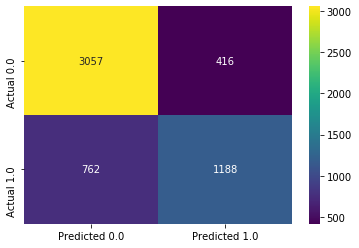

In [14]:
#confusion matrix
y_pred = model.predict(X_test)

def plot_confusion_matrix(y_true, y_pred):
    labels = unique_labels(y_true)
    columns = [f'Predicted {label}' for label in labels]
    index = [f'Actual {label}' for label in labels]
    table = pd.DataFrame(confusion_matrix(y_true, y_pred), 
                         columns=columns, index=index)
    return sns.heatmap(table, annot=True, fmt='d', cmap='viridis')

plot_confusion_matrix(y_test, y_pred);
#some issues with false negatives

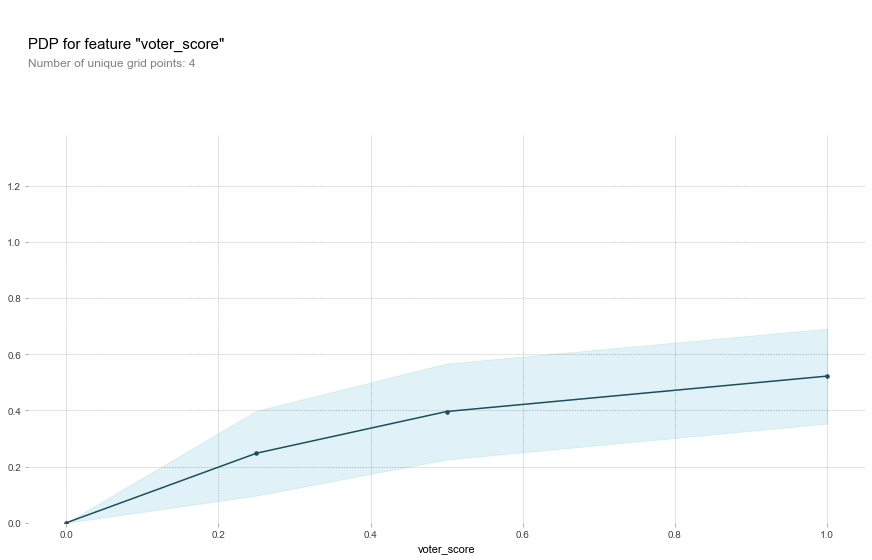

In [15]:
#pdp, one feature isolation
feature = 'voter_score'

isolated = pdp_isolate(
    model=model, 
    dataset=X_test, 
    model_features=X_test.columns, 
    feature=feature
)

pdp_plot(isolated, feature_name=feature);

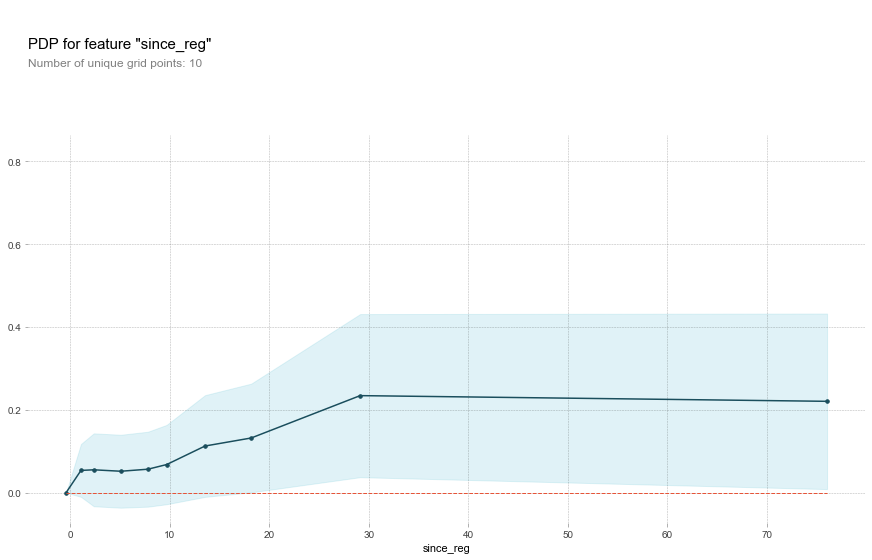

In [16]:
feature = 'since_reg'

isolated = pdp_isolate(
    model=model, 
    dataset=X_test, 
    model_features=X_test.columns, 
    feature=feature
)

pdp_plot(isolated, feature_name=feature);

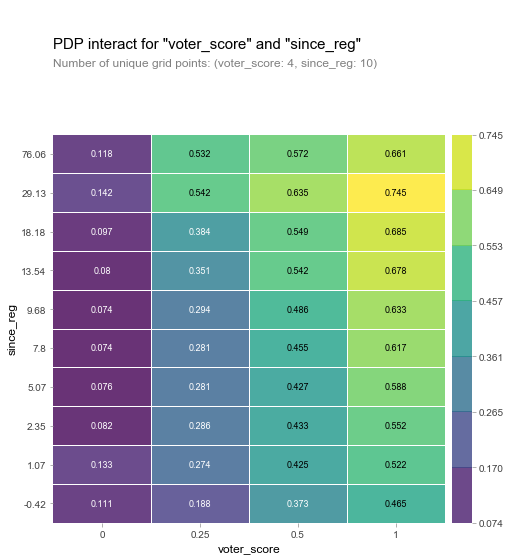

In [17]:
#pdp, two feature interaction
features = ['voter_score', 'since_reg']

interaction = pdp_interact(
    model=model, 
    dataset=X_test, 
    model_features=X_test.columns, 
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);
#now THAT is a lovely interaction!!!

In [18]:
#shapley values
row = X_test.iloc[[4]]

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(row)

print(y_test.iloc[4])
shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values, 
    features=row
)


1.0


# Pipeline for Pickling

In [20]:
pipeline = make_pipeline(
    XGBClassifier(max_depth=4, learning_rate=0.1, n_estimators=86, 
                  random_state=42, n_jobs=-1)
)

#train it on all the data
target = '11/07/2017'
features = ['11/08/2016','06/06/2017','06/07/2016','06/02/2015','male','female',
            'age_2017','voter_score','since_reg','reg_age','dem','rep','una','3rd',
           'municipality']

X = df[features]
y = df[target]

pipeline.fit(X, y)

Pipeline(memory=None,
         steps=[('xgbclassifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.1,
                               max_delta_step=0, max_depth=4,
                               min_child_weight=1, missing=None,
                               n_estimators=86, n_jobs=-1, nthread=None,
                               objective='binary:logistic', random_state=42,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               seed=None, silent=None, subsample=1,
                               verbosity=1))],
         verbose=False)

In [21]:
from joblib import dump

In [22]:
dump(pipeline, 'pipeline.joblib', compress=True)

['pipeline.joblib']

In [29]:
import joblib
import xgboost
import sklearn

print(f'joblib=={joblib.__version__}')
print(f'xgboost=={xgboost.__version__}')
print(f'sklearn=={sklearn.__version__}')

joblib==0.13.2
xgboost==0.90
sklearn==0.21.2
